In [1]:
import pathlib as pl
import re

import pandas as pd

from pyprojroot import here

In [2]:
def color_pos(val):
    color = 'red' if val is True else 'black'
    return 'color: %s' % color

In [3]:
kw_metadata_df = pd.read_pickle(here("./data/db/working/kaggle/id_model_inputs/02-kw_w_metadata.pickle"))

In [4]:
kw_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33503 entries, 0 to 33502
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pid                         33503 non-null  object 
 1   title_x                     33503 non-null  object 
 2   has-incubation_period       33503 non-null  bool   
 3   has-infectiousness_period   33503 non-null  bool   
 4   has-recovery_rate           33503 non-null  bool   
 5   has-case_fatality_ratio     33503 non-null  bool   
 6   has-asymptomatic_fraction   33503 non-null  bool   
 7   has-hospitalized_fraction   33503 non-null  bool   
 8   text_sent                   33503 non-null  object 
 9   sent-incubation_period_day  33503 non-null  object 
 10  sent-infectiousness_period  33503 non-null  object 
 11  sent-recovery_rate          33503 non-null  object 
 12  sent-case_fatality_ratio    33503 non-null  object 
 13  sent-asymptomatic_fraction  335

## Filter on any sentence matches

papers that have at least 1 keyword match

In [5]:
kw_metadata_df['any_has'] = kw_metadata_df.filter(like="has-").apply(any, axis=1)
kw_metadata_df['any_sent'] = kw_metadata_df.filter(like="sent-").astype(bool).apply(any, axis=1)

In [6]:
# any_sent looks at "incubation period day" while any has only looks at "incubation period"
pd.crosstab(kw_metadata_df['any_has'], kw_metadata_df['any_sent'])

any_sent,False,True
any_has,,
False,30610,0
True,1127,1766


In [7]:
kw_metadata_df[(kw_metadata_df['any_sent'] == False) & (kw_metadata_df['any_has'] == True)].filter(regex='has-|sent-')

,has-incubation_period,has-infectiousness_period,has-recovery_rate,has-case_fatality_ratio,has-asymptomatic_fraction,has-hospitalized_fraction,sent-incubation_period_day,sent-infectiousness_period,sent-recovery_rate,sent-case_fatality_ratio,sent-asymptomatic_fraction,sent-hospitalized_fraction
7,True,False,False,False,False,False,[],[],[],[],[],[]
72,True,False,False,False,False,False,[],[],[],[],[],[]
100,True,False,False,False,False,False,[],[],[],[],[],[]
110,True,False,False,False,False,False,[],[],[],[],[],[]
159,True,False,False,False,False,False,[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...
33105,True,False,False,False,False,False,[],[],[],[],[],[]
33313,True,False,False,False,False,False,[],[],[],[],[],[]
33367,True,False,False,False,False,False,[],[],[],[],[],[]
33413,True,False,False,False,False,False,[],[],[],[],[],[]


In [8]:
sent_kw_metadata_df = kw_metadata_df[(kw_metadata_df['any_sent'] == True)]
sent_kw_metadata_df.shape

(1766, 35)

In [9]:
len(sent_kw_metadata_df)

1766

## Which papers contain which KWs

In [10]:
sent_cols = sent_kw_metadata_df.columns[sent_kw_metadata_df.columns.str.contains("sent-")]
sent_cols

Index(['sent-incubation_period_day', 'sent-infectiousness_period',
       'sent-recovery_rate', 'sent-case_fatality_ratio',
       'sent-asymptomatic_fraction', 'sent-hospitalized_fraction'],
      dtype='object')

In [11]:
sent_bool = sent_kw_metadata_df[sent_cols].astype(bool)
sent_bool

,sent-incubation_period_day,sent-infectiousness_period,sent-recovery_rate,sent-case_fatality_ratio,sent-asymptomatic_fraction,sent-hospitalized_fraction
52,True,False,False,False,False,False
61,True,False,False,False,False,False
75,False,False,False,True,False,False
107,True,False,False,False,False,False
166,True,False,False,False,False,False
...,...,...,...,...,...,...
33349,False,False,True,False,False,False
33362,False,False,True,False,False,False
33429,False,False,False,True,False,False
33497,True,False,False,False,False,False


In [12]:
sent_bool['num_matches'] = sent_bool.apply(sum, axis=1)

In [13]:
sent_bool['num_matches'].value_counts()

1    1696
2      66
3       4
Name: num_matches, dtype: int64

In [14]:
num_sent_matches = sent_bool.apply(sum, axis=1).value_counts(dropna=False)
num_sent_matches

2    1696
4      66
6       4
dtype: int64

In [15]:
len(sent_bool)

1766

In [16]:
num_sent_matches.sum()

1766

In [17]:
counts = sent_bool.groupby(list(sent_cols))['num_matches'].sum()

In [18]:
count_df = pd.DataFrame(counts, dtype=int)
count_df.columns = ["count"]
count_df = count_df.reset_index()
count_df['contain_ct'] = count_df.filter(like='sent-').apply(sum, axis=1)

In [19]:
counts = count_df.sort_values(by=["count"], ascending=False)
counts.style.applymap(color_pos)

,sent-incubation_period_day,sent-infectiousness_period,sent-recovery_rate,sent-case_fatality_ratio,sent-asymptomatic_fraction,sent-hospitalized_fraction,count,contain_ct
8,True,False,False,False,False,False,1274,1
2,False,False,True,False,False,False,326,1
1,False,False,False,True,False,False,92,1
10,True,False,True,False,False,False,62,2
9,True,False,False,True,False,False,56,2
11,True,False,True,True,False,False,9,3
4,False,False,True,True,False,False,4,2
12,True,True,False,False,False,False,4,2
13,True,True,False,True,False,False,3,3
0,False,False,False,False,True,False,2,1


In [20]:
count_df.sort_values(['contain_ct'] + sent_cols.tolist()).style.applymap(color_pos)

,sent-incubation_period_day,sent-infectiousness_period,sent-recovery_rate,sent-case_fatality_ratio,sent-asymptomatic_fraction,sent-hospitalized_fraction,count,contain_ct
0,False,False,False,False,True,False,2,1
1,False,False,False,True,False,False,92,1
2,False,False,True,False,False,False,326,1
5,False,True,False,False,False,False,2,1
8,True,False,False,False,False,False,1274,1
3,False,False,True,False,False,True,2,2
4,False,False,True,True,False,False,4,2
6,False,True,False,True,False,False,2,2
7,False,True,True,False,False,False,2,2
9,True,False,False,True,False,False,56,2


In [21]:
1840-1766

74

In [22]:
counts["count"].sum()

1840

In [23]:
len(sent_kw_metadata_df.pid.unique())

1766

In [24]:
sent_long = sent_kw_metadata_df.filter(regex="pid|sent-").melt(id_vars='pid')
sent_long

,pid,variable,value
0,PMC1247620,sent-incubation_period_day,"[A 5-day incubation period, consistent with a ..."
1,PMC1262710,sent-incubation_period_day,"[After an incubation period from 2 to 10 days,..."
2,PMC1298938,sent-incubation_period_day,[]
3,PMC1435713,sent-incubation_period_day,[The mathematical model can be thought of as a...
4,PMC1562405,sent-incubation_period_day,[Information was collected regarding the parti...
...,...,...,...
10591,PMC7200323,sent-hospitalized_fraction,[]
10592,PMC7200851,sent-hospitalized_fraction,[]
10593,PMC7202125,sent-hospitalized_fraction,[]
10594,PMC7204583,sent-hospitalized_fraction,[]


In [25]:
sent_long.loc[sent_long['value'].astype(bool)].pid.duplicated().sum()

74

## Filter on date

In [26]:
sent_kw_metadata_df.shape

(1766, 35)

In [27]:
len(sent_kw_metadata_df)

1766

In [28]:
sent_kw_metadata_df["publish_time_dt"] = pd.to_datetime(sent_kw_metadata_df["publish_time"], yearfirst=True)

earliest_date = pd.to_datetime("2019-06-01", yearfirst=True)
earliest_date

<ipython-input-28-38ab7d59dc5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_kw_metadata_df["publish_time_dt"] = pd.to_datetime(sent_kw_metadata_df["publish_time"], yearfirst=True)


Timestamp('2019-06-01 00:00:00')

In [29]:
kw_dt_filtered = sent_kw_metadata_df[(sent_kw_metadata_df["publish_time_dt"] >= earliest_date) & 
                                     (sent_kw_metadata_df["publish_time_dt"] <= pd.to_datetime("today")) # some dates are after today...
                                     ]
kw_dt_filtered.shape

(318, 36)

In [30]:
print(f"number of unique pid's since {earliest_date}: {kw_dt_filtered.pid.unique().shape}")

number of unique pid's since 2019-06-01 00:00:00: (318,)


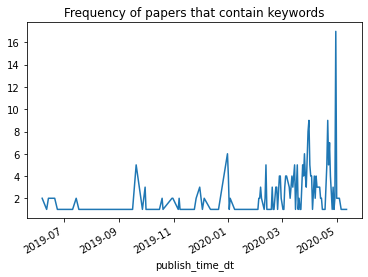

In [31]:
(kw_dt_filtered
 .groupby(["publish_time_dt"])
 .size()
 .sort_index()
 .plot(title="Frequency of papers that contain keywords")
)

#### These are dates that will be problematic in the future

In [32]:
len(sent_kw_metadata_df)

1766

In [33]:
future_dates_df = (sent_kw_metadata_df
                   [(sent_kw_metadata_df["publish_time_dt"] > pd.to_datetime("today"))]
                   [["pid", "publish_time_dt", "title_x", "journal", "url", "doi"]]
                   .sort_values("publish_time_dt")
                   .reset_index(drop=True)
                  )

future_dates_df.shape

(24, 6)

In [34]:
with pd.option_context('display.min_rows', len(future_dates_df), 'display.max_columns', None, 'display.max_colwidth', -1):
    display(future_dates_df)

,pid,publish_time_dt,title_x,journal,url,doi
0,PMC7102525,2020-05-31,Effects of progressive muscle relaxation on anxiety and sleep quality in patients with COVID-19,Complementary Therapies in Clinical Practice,NaN,10.1016/j.ctcp.2020.101132
1,PMC7194575,2020-05-31,"Challenges of SARS-CoV-2 and lessons learnt from SARS in Guangdong Province, China",Journal of Clinical Virology,NaN,10.1016/j.jcv.2020.104341
2,PMC7156809,2020-05-31,Dermatology practices as vectors for COVID-19 transmission: A call for immediate cessation of nonemergent dermatology visits,Journal of the American Academy of Dermatology,NaN,10.1016/j.jaad.2020.03.037
3,PMC7156225,2020-05-31,"Analysis and forecast of COVID-19 spreading in China, Italy and France","Chaos, Solitons & Fractals",NaN,10.1016/j.chaos.2020.109761
4,PMC7198847,2020-05-31,Monitoring the COVID-19 epidemic in the context of widespread local transmission,The Lancet Respiratory Medicine,NaN,10.1016/s2213-2600(20)30162-4
5,PMC7118536,2020-05-31,CT manifestations of coronavirus disease-2019: A retrospective analysis of 73 cases by disease severity,European Journal of Radiology,NaN,10.1016/j.ejrad.2020.108941
6,PMC7128574,2020-05-31,New thinking in the treatment of 2019 novel coronavirus pneumonia,Complementary Therapies in Clinical Practice,NaN,10.1016/j.ctcp.2020.101131
7,PMC7118632,2020-06-07,True epidemic growth construction through harmonic analysis,Journal of Theoretical Biology,NaN,10.1016/j.jtbi.2020.110243
8,PMC7151535,2020-06-15,Central nervous system manifestations of COVID-19: A systematic review,J Neurol Sci,NaN,10.1016/j.jns.2020.116832
9,PMC7165099,2020-06-30,Chest CT findings of COVID-19 pneumonia by duration of symptoms,European Journal of Radiology,NaN,10.1016/j.ejrad.2020.109009


## Filter on covid19 related terms

In [35]:
filter_words_lower_regex = [
    r"covid\s?-?\s?19",
    r"sars-?cov-?2",
    r"ncov"
]
pattern = "|".join(filter_words_lower_regex)
pattern

'covid\\s?-?\\s?19|sars-?cov-?2|ncov'

In [36]:
r = re.compile(pattern)
r

re.compile(r'covid\s?-?\s?19|sars-?cov-?2|ncov', re.UNICODE)

In [37]:
kw_dt_filtered.shape

(318, 36)

In [38]:
kw_dt_filtered.columns

Index(['pid', 'title_x', 'has-incubation_period', 'has-infectiousness_period',
       'has-recovery_rate', 'has-case_fatality_ratio',
       'has-asymptomatic_fraction', 'has-hospitalized_fraction', 'text_sent',
       'sent-incubation_period_day', 'sent-infectiousness_period',
       'sent-recovery_rate', 'sent-case_fatality_ratio',
       'sent-asymptomatic_fraction', 'sent-hospitalized_fraction', 'cord_uid',
       'sha', 'source_x', 'title_y', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 'any_has', 'any_sent', 'publish_time_dt'],
      dtype='object')

In [39]:
p = re.compile("hello")
p.match("hello daniel")

<re.Match object; span=(0, 5), match='hello'>

In [40]:
has_covid_term = kw_dt_filtered['text_sent'].apply(lambda x: any([True for sent in x if r.match(sent.lower())]))

In [41]:
covid_kw_sent = kw_dt_filtered[has_covid_term]

In [42]:
covid_kw_sent.shape

(85, 36)

In [43]:
covid_kw_sent

,pid,title_x,has-incubation_period,has-infectiousness_period,has-recovery_rate,has-case_fatality_ratio,has-asymptomatic_fraction,has-hospitalized_fraction,text_sent,sent-incubation_period_day,...,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,any_has,any_sent,publish_time_dt
13860,PMC7060195,The outbreak of SARS-CoV-2 pneumonia calls for...,True,False,False,False,False,False,[An outbreak of 2019-novel coronavirus (SARS-C...,[COVID-19 spreads rapidly by human-to-human tr...,...,NPJ Vaccines,NaN,#5826,NaN,document_parses/pdf_json/16055daee3891de0d5fb2...,document_parses/pmc_json/PMC7060195.xml.json,NaN,True,True,2020-03-06
13974,PMC7077191,Systematic Comparison of Two Animal-to-Human T...,True,False,False,False,False,False,[Coronaviruses (CoVs) are a group of viruses t...,[The incubation period of SARS is 1–4 days [33...,...,Viruses,2.163319e+09,#1449,NaN,document_parses/pdf_json/f294f0df7468a8ac9e277...,document_parses/pmc_json/PMC7077191.xml.json,NaN,True,True,2020-02-22
14259,PMC7084952,Immediate Psychological Responses and Associat...,True,False,False,False,False,False,[The 2019 coronavirus disease (COVID-19) epide...,[The average incubation period is estimated to...,...,Int J Environ Res Public Health,1.994585e+09,#5504,NaN,document_parses/pdf_json/fdfd585d89aa2ad3f6e8c...,document_parses/pmc_json/PMC7084952.xml.json,NaN,True,True,2020-03-06
15391,PMC7092819,Clinical Characteristics of Coronavirus Diseas...,True,False,False,False,False,False,[The study was supported by National Health Co...,[We excluded incubation periods of less than 1...,...,N Engl J Med,3.005478e+09,#2822,NaN,document_parses/pdf_json/08355a026b85185c0f71a...,document_parses/pmc_json/PMC7092819.xml.json,NaN,True,True,2020-02-28
16127,PMC7095779,Emergence of a novel human coronavirus threate...,True,False,False,False,False,False,[It is increasingly recognized that coronaviru...,[estimated that the mean incubation period of ...,...,Nat Med,2.127594e+09,#2567,NaN,NaN,document_parses/pmc_json/PMC7095779.xml.json,NaN,True,True,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33255,PMC7198455,Prevention of nosocomial COVID-19: Another cha...,True,False,False,False,False,False,[To the Editor—Coronavirus disease 2019 (COVID...,[The incubation period varies between 4 and 14...,...,NaN,NaN,NaN,NaN,document_parses/pdf_json/d9079e8a37d1a7c8107ff...,document_parses/pmc_json/PMC7198455.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,True,True,2020-04-23
33277,PMC7199242,COVID-19: Review of Epidemiology and Potential...,True,False,False,False,False,False,"[1., Introduction\n\n\n2., Etiology\n\n\n3., E...",[The virus is believed to have incubation peri...,...,NaN,NaN,NaN,NaN,document_parses/pdf_json/c540b5c7f8fda5460d058...,document_parses/pmc_json/PMC7199242.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,True,True,2020-04-26
33362,PMC7200851,Critical role of Wuhan cabin hospitals in cont...,False,False,True,False,False,False,[To the Editor—COVID-19 is quickly spreading a...,[],...,NaN,NaN,NaN,NaN,document_parses/pdf_json/47f7f812dc13619f30838...,document_parses/pmc_json/PMC7200851.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,True,True,2020-04-22
33429,PMC7202125,COVID-19: POSTMORTEM DIAGNOSTIC AND BIOSAFETY ...,False,False,False,True,False,False,[SARS-CoV-2 is a novel human coronavirus that ...,[],...,Am J Forensic Med Pathol,NaN,NaN,NaN,document_parses/pdf_json/6b45aa983702a9425fd66...,document_parses/pmc_json/PMC7202125.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,True,True,2020-04-24


## Explode sentences

In [44]:
covid_kw_sent.pid.duplicated().any()

False

In [45]:
sent_cols.to_list()

['sent-incubation_period_day',
 'sent-infectiousness_period',
 'sent-recovery_rate',
 'sent-case_fatality_ratio',
 'sent-asymptomatic_fraction',
 'sent-hospitalized_fraction']

In [46]:
non_sent_cols = ["pid", "title", "publish_time_dt", 'doi', 'url']
non_sent_cols

['pid', 'title', 'publish_time_dt', 'doi', 'url']

In [47]:
covid_kw_sent_subset = covid_kw_sent.rename(columns={"title_x": "title"})[non_sent_cols + sent_cols.to_list()]
covid_kw_sent_subset

,pid,title,publish_time_dt,doi,url,sent-incubation_period_day,sent-infectiousness_period,sent-recovery_rate,sent-case_fatality_ratio,sent-asymptomatic_fraction,sent-hospitalized_fraction
13860,PMC7060195,The outbreak of SARS-CoV-2 pneumonia calls for...,2020-03-06,10.1038/s41541-020-0170-0,NaN,[COVID-19 spreads rapidly by human-to-human tr...,[],[],[],[],[]
13974,PMC7077191,Systematic Comparison of Two Animal-to-Human T...,2020-02-22,10.3390/v12020244,NaN,[The incubation period of SARS is 1–4 days [33...,[],[],[],[],[]
14259,PMC7084952,Immediate Psychological Responses and Associat...,2020-03-06,10.3390/ijerph17051729,NaN,[The average incubation period is estimated to...,[],[],[],[],[]
15391,PMC7092819,Clinical Characteristics of Coronavirus Diseas...,2020-02-28,10.1056/nejmoa2002032,NaN,[We excluded incubation periods of less than 1...,[],[],[],[],[]
16127,PMC7095779,Emergence of a novel human coronavirus threate...,2020-02-27,10.1038/s41591-020-0796-5,NaN,[estimated that the mean incubation period of ...,[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...
33255,PMC7198455,Prevention of nosocomial COVID-19: Another cha...,2020-04-23,10.1017/ice.2020.166,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,[The incubation period varies between 4 and 14...,[],[],[],[],[]
33277,PMC7199242,COVID-19: Review of Epidemiology and Potential...,2020-04-26,10.15190/d.2020.5,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,[The virus is believed to have incubation peri...,[],[],[],[],[]
33362,PMC7200851,Critical role of Wuhan cabin hospitals in cont...,2020-04-22,10.1017/ice.2020.167,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,[],[],[We obtained the data regarding total daily be...,[],[],[]
33429,PMC7202125,COVID-19: POSTMORTEM DIAGNOSTIC AND BIOSAFETY ...,2020-04-24,10.1097/paf.0000000000000567,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,[],[],[],"[7,8\nCase fatality ratios range widely from 0...",[],[]


In [48]:
exploded_df_list = []

for idx, sc in enumerate(sent_cols):
    print(idx, sc)
    exploded = covid_kw_sent_subset[non_sent_cols + [sc]].explode(sc).dropna()
    exploded = exploded.rename({sc: "sentence"}, axis='columns')
    exploded['match_type'] = sc
    display(exploded)
    exploded_df_list.append(exploded)

0 sent-incubation_period_day


,pid,title,publish_time_dt,doi,url,sentence,match_type
16339,PMC7098028,COVID-19: what has been learned and to be lear...,2020-03-15,10.7150/ijbs.45134,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,The average incubation period was 4.8 (3.0-7.2...,sent-incubation_period_day
16339,PMC7098028,COVID-19: what has been learned and to be lear...,2020-03-15,10.7150/ijbs.45134,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,The estimated mean incubation period of SARS-C...,sent-incubation_period_day
16339,PMC7098028,COVID-19: what has been learned and to be lear...,2020-03-15,10.7150/ijbs.45134,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"However, a study on 1,099 cases demonstrates t...",sent-incubation_period_day
16339,PMC7098028,COVID-19: what has been learned and to be lear...,2020-03-15,10.7150/ijbs.45134,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"A more recent study, as described above, demon...",sent-incubation_period_day
16341,PMC7098030,SARS-CoV-2: an Emerging Coronavirus that Cause...,2020-03-15,10.7150/ijbs.45053,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Analysis of 425 patients with confirmed COVID-...,sent-incubation_period_day
...,...,...,...,...,...,...,...
33277,PMC7199242,COVID-19: Review of Epidemiology and Potential...,2020-04-26,10.15190/d.2020.5,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,The Chinese National Health Commission initial...,sent-incubation_period_day
33277,PMC7199242,COVID-19: Review of Epidemiology and Potential...,2020-04-26,10.15190/d.2020.5,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,The Centers for Disease Control and Prevention...,sent-incubation_period_day
33277,PMC7199242,COVID-19: Review of Epidemiology and Potential...,2020-04-26,10.15190/d.2020.5,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"Doctors and health-care practitioners, of lead...",sent-incubation_period_day
33277,PMC7199242,COVID-19: Review of Epidemiology and Potential...,2020-04-26,10.15190/d.2020.5,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"Nevertheless, more recently, in a JAMA report ...",sent-incubation_period_day


1 sent-infectiousness_period


,pid,title,publish_time_dt,doi,url,sentence,match_type


2 sent-recovery_rate


,pid,title,publish_time_dt,doi,url,sentence,match_type
17026,PMC7104689,Cross-Country Comparison of Case Fatality Rate...,2020-04-12,10.24171/j.phrp.2020.11.2.03,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Given the importance of CFR and recovery rate ...,sent-recovery_rate
17026,PMC7104689,Cross-Country Comparison of Case Fatality Rate...,2020-04-12,10.24171/j.phrp.2020.11.2.03,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,China showed encouraging recovery rates from C...,sent-recovery_rate
17026,PMC7104689,Cross-Country Comparison of Case Fatality Rate...,2020-04-12,10.24171/j.phrp.2020.11.2.03,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Although the COVID-19 outbreak has led to high...,sent-recovery_rate
30108,PMC7164711,An Epidemiological Study on COVID-19: A Rapidl...,2020-03-18,10.7759/cureus.7313,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,This is also complemented by a high recovery r...,sent-recovery_rate
30108,PMC7164711,An Epidemiological Study on COVID-19: A Rapidl...,2020-03-18,10.7759/cureus.7313,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Subsequent continuous decrease in mortality ra...,sent-recovery_rate
31859,PMC7177691,The First 75 Days of Novel Coronavirus (SARS-C...,2020-03-30,10.3390/ijerph17072323,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Hospital discharge rates vary between 5% and 6...,sent-recovery_rate
31966,PMC7179791,Sexual and reproductive health (SRH): a key is...,2020-04-23,10.1186/s12978-020-0900-9,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"For both men and women, questions around wheth...",sent-recovery_rate
32733,PMC7189398,Preparing for the Perpetual Challenges of Pand...,2020-04-30,10.1007/978-981-15-4814-7_14,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,It depends on the transmission rate (β).Incuba...,sent-recovery_rate
33093,PMC7195979,Antiviral treatment of COVID-19,2020-04-21,10.3906/sag-2004-145,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"In patients with mild-moderate COVID-19, 7 day...",sent-recovery_rate
33128,PMC7196894,"The COVID-19 epidemic, its mortality, and the ...",2020-04-30,10.1177/2048872620924922,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,COVID-19 has a wide spectrum of clinical sever...,sent-recovery_rate


3 sent-case_fatality_ratio


,pid,title,publish_time_dt,doi,url,sentence,match_type
31295,PMC7169834,A new threat from an old enemy: Re-emergence o...,2020-03-27,10.3892/ijmm.2020.4555,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"Likewise, data from Italy as of 15/3/20 indica...",sent-case_fatality_ratio
31295,PMC7169834,A new threat from an old enemy: Re-emergence o...,2020-03-27,10.3892/ijmm.2020.4555,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Whilst the older population demographics of It...,sent-case_fatality_ratio
33429,PMC7202125,COVID-19: POSTMORTEM DIAGNOSTIC AND BIOSAFETY ...,2020-04-24,10.1097/paf.0000000000000567,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"7,8\nCase fatality ratios range widely from 0....",sent-case_fatality_ratio


4 sent-asymptomatic_fraction


,pid,title,publish_time_dt,doi,url,sentence,match_type


5 sent-hospitalized_fraction


,pid,title,publish_time_dt,doi,url,sentence,match_type


In [49]:
explode_df = pd.concat(exploded_df_list)

In [50]:
print(f"Number of unique pids: {explode_df.pid.unique().shape}")

Number of unique pids: (64,)


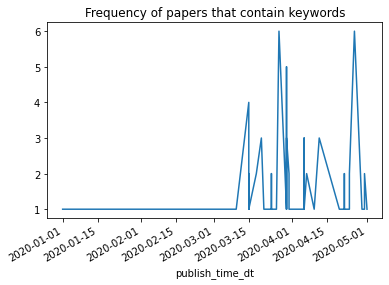

In [51]:
(explode_df
 .groupby(["pid", "publish_time_dt"])
 .size()
 .droplevel("pid")
 .sort_index()
 .plot(title="Frequency of papers that contain keywords")
)

## Matched keyword sentences for papers talking about covid19

In [52]:
with pd.option_context('display.min_rows', 50, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(explode_df)

,pid,title,publish_time_dt,doi,url,sentence,match_type
16339,PMC7098028,COVID-19: what has been learned and to be learned about the novel coronavirus disease,2020-03-15,10.7150/ijbs.45134,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7098028/,The average incubation period was 4.8 (3.0-7.2) days.,sent-incubation_period_day
16339,PMC7098028,COVID-19: what has been learned and to be learned about the novel coronavirus disease,2020-03-15,10.7150/ijbs.45134,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7098028/,"The estimated mean incubation period of SARS-CoV-2 is 1-14 days, mostly 3-7 days based on a study of the first 425 cases in Wuhan 36.",sent-incubation_period_day
16339,PMC7098028,COVID-19: what has been learned and to be learned about the novel coronavirus disease,2020-03-15,10.7150/ijbs.45134,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7098028/,"However, a study on 1,099 cases demonstrates that the incubation period was 3 days on average and ranged from 0 to 24 days 8.",sent-incubation_period_day
16339,PMC7098028,COVID-19: what has been learned and to be learned about the novel coronavirus disease,2020-03-15,10.7150/ijbs.45134,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7098028/,"A more recent study, as described above, demonstrates that the incubation period was 4.8 (3.0-7.2) days based on the demography of 8,866 cases 37.",sent-incubation_period_day
16341,PMC7098030,SARS-CoV-2: an Emerging Coronavirus that Causes a Global Threat,2020-03-15,10.7150/ijbs.45053,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7098030/,Analysis of 425 patients with confirmed COVID-19 showed that the incubation period is 3 to 7 days.,sent-incubation_period_day
16341,PMC7098030,SARS-CoV-2: an Emerging Coronavirus that Causes a Global Threat,2020-03-15,10.7150/ijbs.45053,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7098030/,"Notably, it was reported that the incubation period could be as long as 24 days in a rare case 25.",sent-incubation_period_day
16342,PMC7098031,Zoonotic origins of human coronaviruses,2020-03-15,10.7150/ijbs.45472,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7098031/,"Apart from the super-spreaders, it was estimated that each case could give rise to approximately two secondary cases, with an incubation period of 4 to 7 days and the peak of viral load appearing on the 10th day of illness 14,15.",sent-incubation_period_day
17917,PMC7107962,Occupational risks for COVID-19 infection,2020-02-28,10.1093/occmed/kqaa036,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7107962/,An analysis of the first 425 cases provided an estimated mean incubation period of 5.2 days (95% confidence interval [CI] 4.1–7.0) and a basic reproductive number (Ro) of 2.2 (95% CI 1.4–3.9) [1].,sent-incubation_period_day
20052,PMC7113464,Advice on Standardized Diagnosis and Treatment for Spinal Diseases during the Coronavirus Disease 2019 Pandemic,2020-03-30,10.31616/asj.2020.0122,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7113464/,"The incubation period of COVID-19 is usually 3–7 days and no more than 14 days, while it can also last up to 24 days in rare cases.",sent-incubation_period_day
23117,PMC7123290,"Coronavirus Disease (COVID-19) and Pediatric Patients: A Review of Epidemiology, Symptomatology, Laboratory and Imaging Results to Guide the Development of a Management Algorithm",2020-03-31,10.7759/cureus.7485,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7123290/,"noted within their study that the mean incubation period in their set of pediatric patients from household exposure to a symptomatic adult case was six and a half days, which they noted to be suggestive of a longer incubation period than what is being reported in adults [5].",sent-incubation_period_day


In [53]:
pl.Path(here("./data/db/final/kaggle/id_model_inputs/", warn=False)).mkdir(parents=True, exist_ok=True)
explode_df.to_csv(here("./data/db/final/kaggle/id_model_inputs/03-covid_kw_sentences.tsv"), sep="\t", index=False)